In [1]:
#Initialisation
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
from scipy import signal as sg
from scipy.interpolate import RectBivariateSpline as ReBiSpline
from numpy import ma
from matplotlib import colors, ticker, cm
from random import choice
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import timeit
import math
import cv2
from PIL import Image
import elevation_import as elev

%matplotlib inline

In [2]:
locSelect = [53.061473, -4.085126]
areaWidth = 420
areaName = 'Rhyd Ddu Path, Snowdon, Wales'

testElev = elev.Elevation(areaName, locSelect[0], locSelect[1], areaWidth)
elevValue = testElev.elev_interpolation()
#
#
# plt.imshow(elevValue)

Elevation found for Rhyd Ddu Path, Snowdon, Wales
[53.061473, -4.085126]
request skipped


In [3]:
# Base = np.array(np.zeros((areaWidth,areaWidth,3)))
#
# plt.imshow(Base)

In [4]:
# TODO: image input?
# Read grids from image
im = Image.open("images/flat.bmp")
Base = np.array(im)

In [5]:
# Define internal quantities and variables
scale = 1  # m per pixel
Nx = Base[:,0,0].size  # N appears to be resolution
Ny = Base[0,:,0].size  # Nx,Ny is size, Nz is RGB level
xmin=-scale*0.5*(Nx-1)
xmax=scale*0.5*(Nx-1)
ymin=-scale*0.5*(Ny-1)
ymax=scale*0.5*(Ny-1)
x = np.linspace(xmin, xmax, Nx) # This is defining the axes and full space
y = np.linspace(ymin, ymax, Ny)
Y, X= np.meshgrid(y, x)
TrailPotential = np.zeros((Nx,Ny))
DestinationPotential=np.zeros((Nx,Ny))
Weight=np.zeros((Nx,Ny))  # Create gradient to sit on Nx, Ny
intens=np.zeros((Nx,Ny))
q_alpha=np.zeros((Nx,Ny))
expdist=np.zeros((2*Nx-1,2*Ny-1))
dest=np.zeros((2))
start=np.zeros((2))
grad=np.zeros((2,Nx,Ny))
vel=np.asarray([0.,0.])
pos=np.asarray([0.,0.])
#desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
#desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)
intens[:]=0.

#print(route)
#parameters
t_track=50. # Track decay time - after 50 walkers ignore a trail, it decays by 1/e
dt=0.1  # dt per time step, continuous markings every dt metres
dvel=3. # desired walker velocity in m/s
tau=5.
isigma=1./2. # trail potential
conv_thresh=10.e-4
precision=1.**2 #distance to target.
eps=0.025 #random motion contribution, same for all
prevDir = 0 # record of previous angle of direction
p_alpha = 0.3 # value of persistence
theta_max = .2  # maximum permissible ascent angle (30 degrees)

In [6]:
class Slope:
    def __init__(self, posx, posy):
        xdir = 0.8*g_slope[0][posx][posy] # horizontal slope component at pos, scaled
        ydir = 0.8*g_slope[1][posx][posy] # vertical slope component at pos
        self.xdir = xdir
        self.ydir = ydir
        self.mod = math.sqrt(xdir**2 + ydir**2)  # modulus of the gradient
        #if self.xdir == 0: # 0 exception for gradient singnularity
            # Assign angle of the gradient vector
        #    if self.ydir > 0:
        #        self.angle = math.pi/2
       #     elif self.ydir <= 0:
        #        self.angle = -math.pi/2
        #else:
        self.angle = np.arctan2(self.ydir,self.xdir)  # direction of the gradient vector  # np.arctan2() - gets result in correct quadriant
        # end __init__()

    def forbidden_angle(self, curDir):


        # (?) Still include
        # grad_max = math.tan(theta_max)
        # if self.mod < grad_max:
        #     # Ignore gradient processing if maximum gradient is not exceeded anywhere
        #     return curDir
        # else:
        # curDir = persistence(curDir) # Apply the persistence (step 7)
        # Calculate forbidden angle (alpha)
        thetaSlope = math.atan(self.mod)  # angle of the slope relative from ground to the height
        if ((self.mod or thetaSlope) == 0 ) or (thetaSlope < theta_max):
            # print("Continue (CurDir = " + str(curDir) + ") (grad = " + str(self.angle) + ") slope = ",thetaSlope)
            return curDir
        alpha = (math.pi/2 - math.asin(math.tan(theta_max)/math.tan(thetaSlope)))  # Forbidden angle from the gradient value (*)

        # Distinguish the deviation of the current direction from the closest forbidden angle and assign the new current direction accordingly
        curDir = curDir % (2*np.pi) # convert to 2pi
        # Difference between current direction and gradient, zipped around so it is always between +pi and -pi
        deviation = (curDir-self.angle + 0.5*np.pi) % np.pi - 0.5*np.pi  # deviation between pi/2 and -pi/2, absolute value
        # print('deviation = ', deviation)
        if np.abs(deviation)>alpha:
            # print('Final value unchanged \n (curDir = ' + str(curDir) + " grad = " + str(self.angle) + ") (alpha =" + str(alpha)+ ") slope = ",thetaSlope,")")
            return curDir # Current direction remains unchanged as it is outside of the forbidden zone
        if deviation < 0:
            # print("push right (CurDir =" + str(curDir) + ") (grad = " + str(self.angle) + ") (alpha =" + str(alpha)+ ") slope = ",thetaSlope,")")
            curDir = curDir-deviation-alpha  # curDir - deviation = grad (or opposite), curDir not subjected to mod
        else:
            # print("push left (CurDir =" + str(curDir) + ") (grad = " + str(self.angle) + ") (alpha =" + str(alpha)+ ") slope = ",thetaSlope,")")
            curDir = curDir-deviation+alpha

        print(curDir)
        # Convert back to [-pi,pi]
        if (0 <= curDir <= np.pi) or (curDir > 2 * np.pi):
            curDir = (curDir % (2*np.pi))
            return curDir
        elif (np.pi < curDir < 2 * np.pi) or (curDir < 0): # Place curDir within [-pi:0]
            curDir = (curDir % (2*np.pi)) - 2 * np.pi
            return curDir
        # end forbidden_angle()

In [7]:
##Set up map
#Create blank arrays for map
z = np.zeros((Nx,Ny))
g_max=np.zeros((Nx,Ny)) # empty matrix
g_nat=np.zeros((Nx,Ny))
g_grad=np.zeros((Nx,Ny))

g_nat=np.maximum(np.ones_like(g_nat),np.float64(Base[:,:,0])) # red channel, np.ones_like() sets minimum value to 1
g_max=np.maximum(np.ones_like(g_max),np.float64(Base[:,:,1])) # green channel
# g_height=np.maximum(np.ones_like(g_grad),np.float64(Base[:,:,2])) # blue channel
g_height = elevValue
# g_height=np.fromfunction(lambda i, j: 0.27*(i ), (Nx, Ny), dtype=float) # Set custom gradient
g_height = cv2.GaussianBlur(g_height,(5,5),2) # Apply 2D convolution using a gaussian kernel
z=g_nat

# Trails (start and end point) For current Map, coordinates in metres, centre of image = (0,0)

# single possible path
route=np.array([[10,9.75],[-10.,-9.75]])
# route=np.array([[24.,9.75],[-24.,-9.75]])

# commented out for single path

# route=np.array([[[-2.5,14.],[24.,-9.75]],
#                 [[-2.5,14.],[24.,2.5]],
#                 [[-2.5,14.],[-24.,9.75]],
#                 [[24.,-9.75],[-2.75,14.]],
#                 [[24.,-9.75],[-24.,9.75]],
#                 [[24.,2.5],[-2.75,14.]],
#                 [[24.,2.5],[-24.,9.75]],
#                 [[-24.,10.],[-2.75,14.]],
#                 [[-24.,10.],[24.,-9.75]],
#                 [[-24.,10.],[24.,2.5]]])


In [8]:
#Setup weight matrix, here trapezoid rule.
Weight[:,:]=1
Weight[1:-1,:]=2
Weight[:,1:-1]=2
Weight[1:-1,1:-1]=4
Weight*=0.25*((x[-1]-x[0])/(Nx-1))*((y[-1]-y[0])/(Ny-1))
#0.25*((x[-1]-x[0])/(N-1))*((y[-1]-y[0])/(N-1))
#np.exp(-np.sqrt((x[:,None]-x[N/2])**2+(y[None,:]-y[N/2])**2))*z[:,:]

In [9]:
# Setup distance matrix
for xi in range(1,Nx+1):
    for yi in range(1,Ny+1):

        expdist[xi-1,yi-1]=np.exp(-isigma*np.sqrt((x[Nx-xi]-xmin)**2+(y[Ny-yi]-ymin)**2))
        expdist[-xi,-yi]  = expdist[xi-1,yi-1]
        expdist[-xi,yi-1] = expdist[xi-1,yi-1]
        expdist[xi-1,-yi] = expdist[xi-1,yi-1]

# find index range > conv_thresh
subexpdist=expdist[(expdist>conv_thresh).any(1)]
subexpdist=subexpdist[:, np.any(subexpdist>conv_thresh, axis=0)]
#subexpdist=subexpdist[:,np.any(subexpdist>conv_thresh, axis=0)]
#expdist[subexpdist]=0.
subexpdist.shape
#expdist
#subexpdist


(27, 27)

In [10]:
def calc_tr_new():
    TrailPotential[:,:]=sg.convolve2d(z[:,:]*Weight[:,:],subexpdist[:,:],mode="same")  # 2D convolution

In [11]:
timeit.timeit(calc_tr_new,number=1)

0.30901780000000034

In [12]:
# Defines a Plot to show the smoothing of the supplied map to represent the respective potentials of the ground, the larger
# the potentials, the more attractive the ground is to the walker

# ???
# cs = plt.contourf(X, Y, TrailPotential, levels=np.linspace(TrailPotential.min(),TrailPotential.max(),1000),cmap='PuBu_r')
# cbar = plt.colorbar()
#
# plt.scatter(track[0:1999,0],track[0:1999,1])
# plt.show()

In [13]:
#set up walker
def set_up_walker(route_id):
    global vel,pos,track,intens,dest,start,route
    #start
    # start=np.array(route[route_id,0,:])  # commented for simplicity
    start = np.array([30.,30.])  # temporary one route
    dest = np.array([-30.,-10.])  # temporary one route
    #dest=(random.choice(ends))
    # dest=np.array(route[route_id,1,:]) # commented for simplicity
    vel=np.array([0.,0.])
    pos=np.array(start)
    #print (pos)
    track=np.zeros((2000,2))
    #track[0,:]=pos[:]

In [14]:
#Calculate gradients eq 19
#Trail gradient
def setup_potentials():
    global grad,desdirx,desdiry,dest
    grad=0.003*np.array(np.gradient(TrailPotential))
    #grad=0.002*np.array(np.gradient(TrailPotential)) ORIGINAL

    #print (dest)
    #Destination potential
    DestinationPotential=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    #Combine gradients
    grad+=np.array(np.gradient(DestinationPotential)[:])
    #Normalise
    #grad[:,:,:]/=(np.sqrt(grad[0,:,:]**2+grad[1,:,:]**2))
    desdirx=ReBiSpline(x,y,grad[0,:,:],s=2) # gradeint plus magnitude, Spline approximation over a rectangular mesh
    desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)
    # angle array, arctans of gradient components, rebislpine
    # continuous desired angles permissible
        # 2pi periodic system aware

In [15]:
# #Plot the direction
# scgrad=np.arctan2(grad[1],grad[0])
# levels = np.linspace(-np.pi, np.pi, 360)
# cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

# cbar = plt.colorbar()
# # ERROR # plt.scatter(track[0:1999,0],track[0:1999,1])
# #plt.scatter(start, dest)
# print(start)
# print(dest)
# plt.show()

In [16]:
def persistence(curDir):
        global prevDir
        # Apply persistence of direction formula (Gilks equation 6) - weighted average of the movement
        gammax= (p_alpha*np.cos(prevDir) + (1 - p_alpha)* np.cos(curDir))
        gammay=(p_alpha*np.sin(prevDir) + (1 - p_alpha)* np.sin(curDir))
                 
        gamma = np.arctan2(gammay,gammax)  # previous direction as estimation
        return gamma

In [17]:
def calc_path():
    global pos,vel,intens,track,dest,dvel,tau, prevDir, desdirx, desdiry
    i=0
    hist=10
    samp=10
    avpos=np.zeros((2,hist))
    #Setup While loop to run until either the walker reaches the destination or the walker has passed 2000 movement cycles to
    #attempt to get there
    while (np.dot(pos-dest,pos-dest)>precision and i<2000): # takes 2000 steps maximum
        #set the postiion of the walker on its first then subsequent cycles
        #conditional logic saying to update the average position of the walker every 10 iterations
        #if (i%samp==0): avpos[:,(i%hist)//samp]=pos[:] #ORIGINAL
        if (i%samp==0):
            avpos[:,(i%(hist*samp))//samp]=pos[:]
        #print((i%hist)//samp)
        # print(avpos)
        gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
        xi=np.array(np.random.normal(0,1,2))
        # Equation 6 in Helbing, differential in position, eliminised velocity decay components
        # gradmagnitude makes sure it is normalised, desdir not normalised
        # pos[0]+= dt *(dvel * desdirx(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[0])  # x-position vector component
        # pos[1]+= dt *(dvel * desdiry(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[1])  # y-position vector component
        # posGrad = math.degree(math.atan(pos[0]/pos[1]) # future position
        curDir = math.atan2(desdiry(pos[0],pos[1]),desdirx(pos[0],pos[1])) # atan2 not to flip walker around
        pos0 = pos[0]
        pos1 = pos[1]
        posx = int(((pos[0]-xmin)*(Nx-1))/(xmax-xmin)) # index value of position x
        posy = int(((pos[1]-ymin)*(Ny-1))/(ymax-ymin)) # index value of position y
        # print('x =' + str(posx) + '  y = ' + str(posy))
        if i == 385:
            print("stop)")
        # print('Curdir = ',curDir,' Persistent = ', persistence(curDir))
        if i>0: # Exception for first step
            curDir = persistence(curDir) # Apply persistence of movement
        curGradient = Slope(posx,posy)  # set the current gradient to the Slope class


        curDir = curGradient.forbidden_angle(curDir) # apply forbidden angle rule
        # if prevDir != curDir:  # the position angle has changed, recalculate the path position ???
        # print("CurDir at " + str(i) + "= " + str(curDir))
        pos[0] += dt * (dvel * math.cos(curDir))
        pos[1] += dt * (dvel * math.sin(curDir))
            # desdiry = math.sin(curDir)
            # desdirx = math.cos(curDir)
            # gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
            # xi=np.array(np.random.normal(0,1,2))
            # pos[0]+= dt *(dvel * desdirx(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[0])  # x-position vector component
            # pos[1]+= dt *(dvel * desdiry(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[1])  # y-position vector component
        prevDir = curDir # applying a back trace of the previous direction# Calculate current facing direction
        # pos+=dt*vel
        #vel[0]+=-1/tau*vel[0] + (dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]   # Eqiation 5 in Helbing, differential in velocity
        #vel[1]+=-1/tau*vel[1] + (dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]



        #Set the current position of the walker into the trakc array for the current iteration
        track[i,:]=pos[:]
        # (pos[0]-xmin)*(Nx-1)/(xmax-xmin)  - scale to resolution [Nx-1] * distance to left edge / width of whole field
        intens[int((pos[0]-xmin)*(Nx-1)/(xmax-xmin)),int((pos[1]-ymin)*(Ny-1)/(ymax-ymin))]+=1.
        i+=1
        if (i%(hist*samp)==0):
            meanpos=np.mean(avpos,axis=1)
            if (np.dot(pos-meanpos,pos-meanpos)<precision):
                print ("Stalled progress ",pos,meanpos,vel, dest)
                break
    if (i==1500): print ("Missed goal ",dest,pos)
    return i
#stopping condition

In [18]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground():
    global q_alpha,intens,z,g_max,t_track,g_nat
    q_alpha=intens*(1.-z/g_max)
    # Time evolution of ground potential
    #zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha
    #cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
    #cbar = plt.colorbar()
    #plt.show
    #z[140:160,45:75]

In [19]:
# TODO: What does this do???
def plot_path_elev():
    plt.contourf(X, Y, g_height, levels=np.linspace(g_height.min(),g_height.max(),1000),cmap='PuBu_r')
    plt.colorbar()
    plt.scatter(track[0:1999,0],track[0:1999,1],1,c='y')
    plt.show(block=False)

In [20]:
def plot_path():
    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    plt.colorbar()
    plt.scatter(track[0:1999,0],track[0:1999,1],1,c='y')
    plt.show(block=False)

In [21]:
tau = 5.

In [22]:
# RUN SIMULATION

g_slope = np.gradient(g_height,1)
grady = g_slope[0] # vertical slope compontent
gradx = g_slope[1] # horizontal slope component
for i in range(0,1):
    calc_tr_new()
    intens[:]=0.
    for j in range(0,1):
        set_up_walker(np.random.randint(0,len(route)))
        setup_potentials()
        calc_path()
        # print(i, start," -> ", dest, pos, calc_path()) **********
    update_ground()
    #plot_path()
print("end")

end


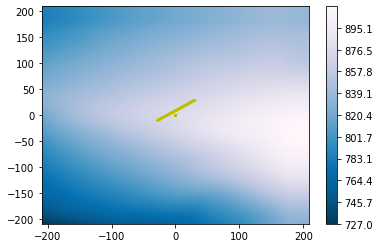

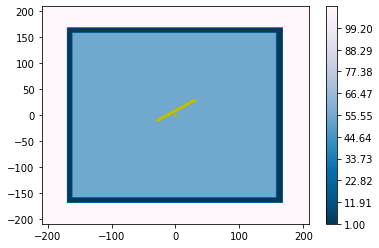

In [23]:
plot_path_elev()
plot_path()

In [24]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],Base[i,j,0])

In [25]:
def detect_local_maxima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    #
    # we create the mask of the background
    background = (arr==0)
    #
    # a little technicality: we must erode the background in order to
    # successfully subtract it from local_min, otherwise a line will
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    #
    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_min mask
    detected_maxima = local_max ^ eroded_background
    return np.where(detected_maxima)

In [26]:
def plot_potentials():
    global dest
    TotPot = np.zeros((Nx,Ny))
    TotPot =- np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    TotPot += 0.003*TrailPotential
    maxima=detect_local_maxima(TotPot)
    cs = plt.contourf(X, Y, TotPot, levels=np.linspace(TotPot.min(),TotPot.max(),1000),cmap='PuBu_r')
    cbar = plt.colorbar()
    print(maxima)
    plt.scatter(x[maxima[0]],y[maxima[1]])
    plt.show()
    # commit test

(array([ 37,  37, 179, 179, 179, 179, 180, 180, 180, 180, 380, 380],
      dtype=int64), array([199, 200,  38, 199, 200, 381,  38, 199, 200, 381, 199, 200],
      dtype=int64))


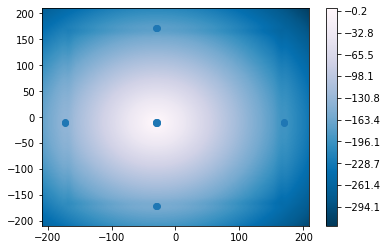

In [27]:
plot_potentials()

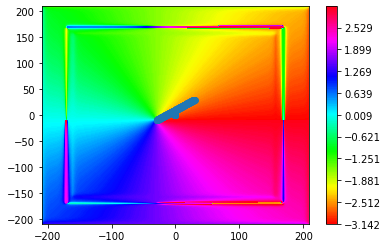

In [28]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

cbar = plt.colorbar()
plt.scatter(track[0:1999,0],track[0:1999,1])
#plt.scatter(start, dest)
# print(start) **************
# print(dest) ***************
plt.show()


In [29]:
# plot_path()

In [30]:
#Integrate z, trapezoid rule eq 20
# def calc_tr():
#    global xi,yi,TrailPotential,expdist,z,Weight,Nx,Ny
#    for xi in range(0,Nx):
#        for yi in range(0,Ny):
#            TrailPotential[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*Weight[:,:])

# Test additional heightS

In [31]:
#Integrate z, trapezoid rule eq 20
# def calc_tr():
#    global xi,yi,TrailPotential,expdist,z,Weight,Nx,Ny
#    for xi in range(0,Nx):
#        for yi in range(0,Ny):
#            TrailPotential[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*Weight[:,:])